In [30]:
import os
import json
import time
from itertools import product

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tabulate import tabulate

import numpy as np
from datetime import datetime


In [31]:
# Importamos datos depurados
df = pd.read_csv('../../Data/dropout_depurado.csv', sep=',')

# Separamos features de target
y = df['Target_bin']
X = df.drop('Target_bin', axis=1)

# Separamos train de test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

Vamos a crear un excel de resultados en el que almacenemos los resultados de cada modelo entrenado: la clase, la parametrizacion, la matriz de confusion en 4 columnas (TP, FP, FN, TN), y las variables input del modelo (si en el futuro el pretratamiento cambia, seremos capaces de rastrearlo y comparar distintos pretratamientos)

Modelo: DecisionTreeClassifier (Prueba)


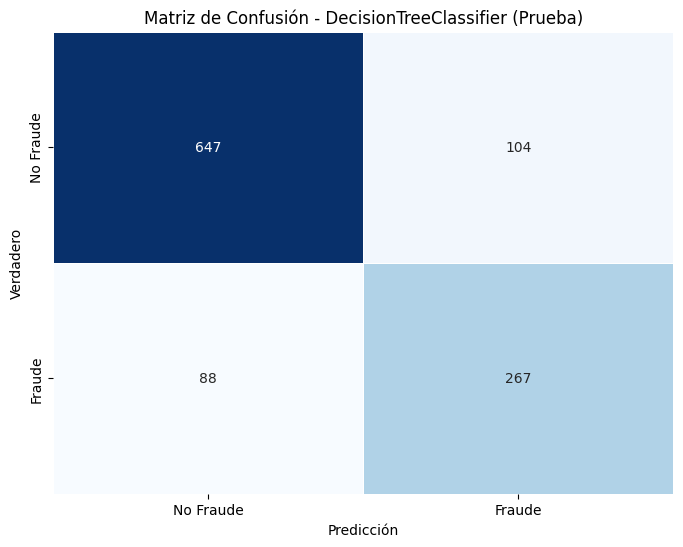

+----+------------------------+---------------------------+------+------+------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


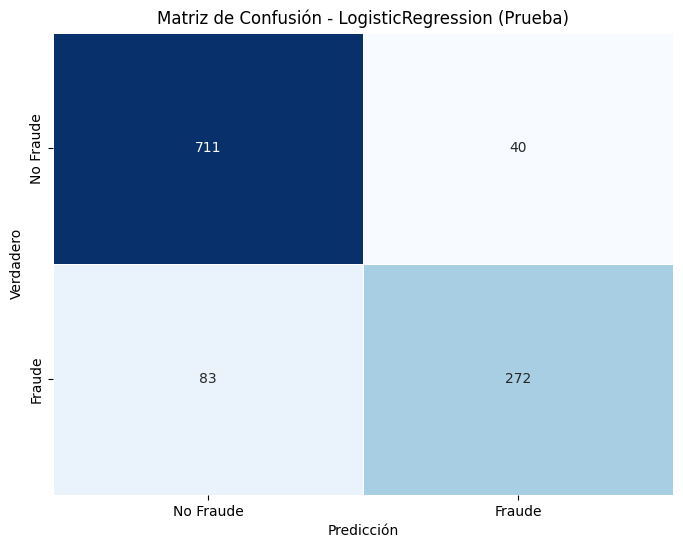

+----+--------------------+---------------------------+------+------+------+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

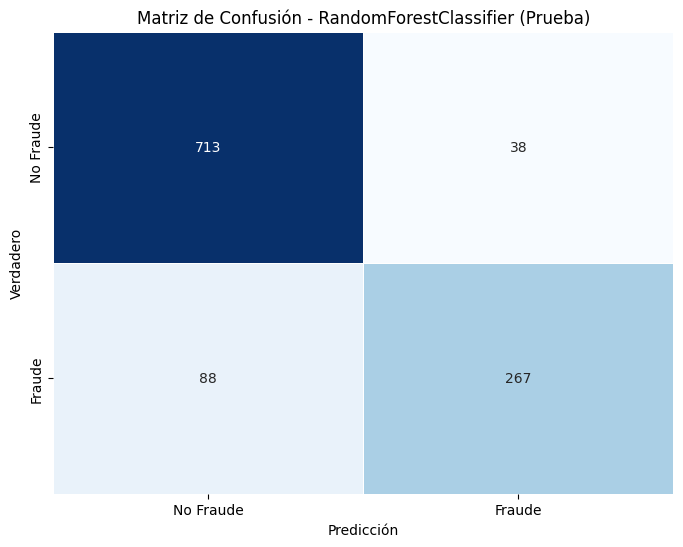

+----+------------------------+---------------------------+------+------+------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

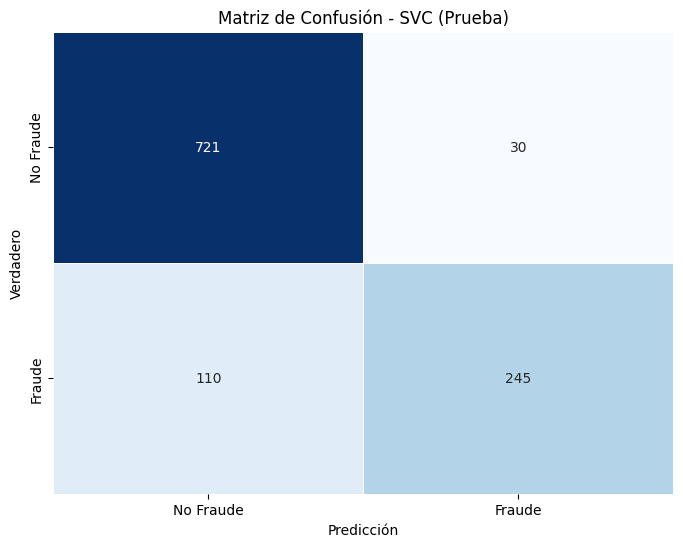

+----+----------+---------------------------+------+------+------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

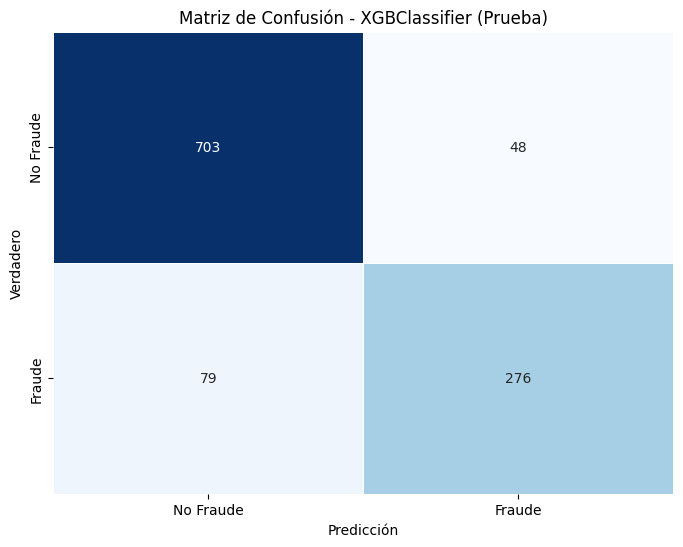

+----+---------------+---------------------------+------+------+------+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------

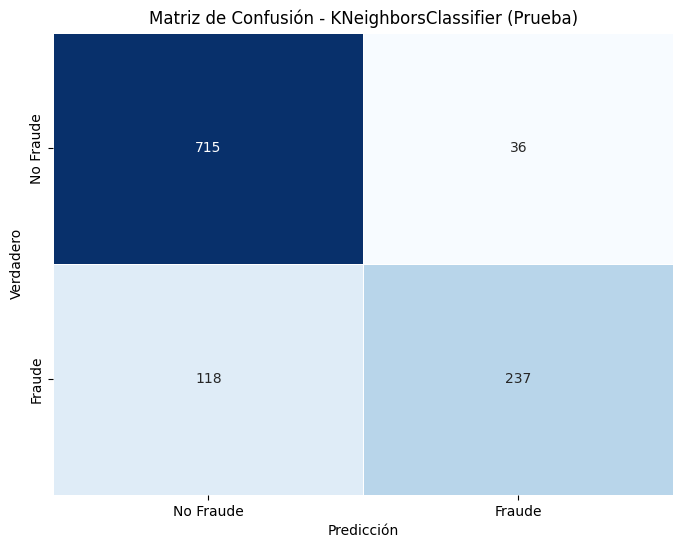

+----+----------------------+---------------------------+------+------+------+------+------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

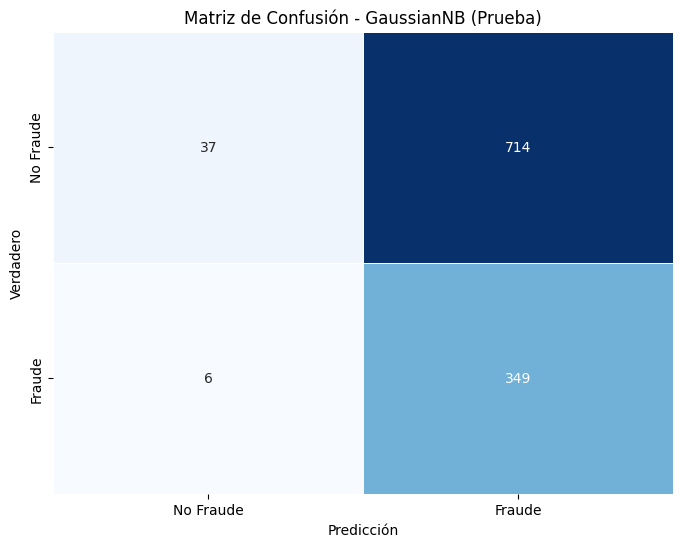

+----+------------+---------------------------+------+------+------+------+------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

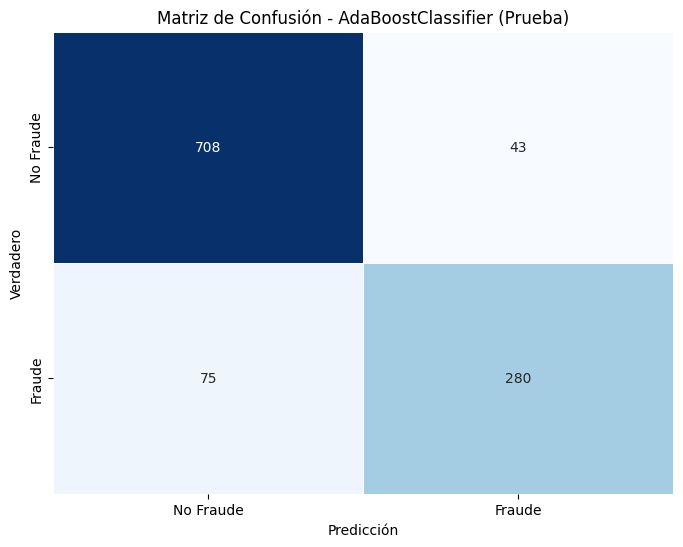

+----+--------------------+---------------------------+------+------+------+------+---------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

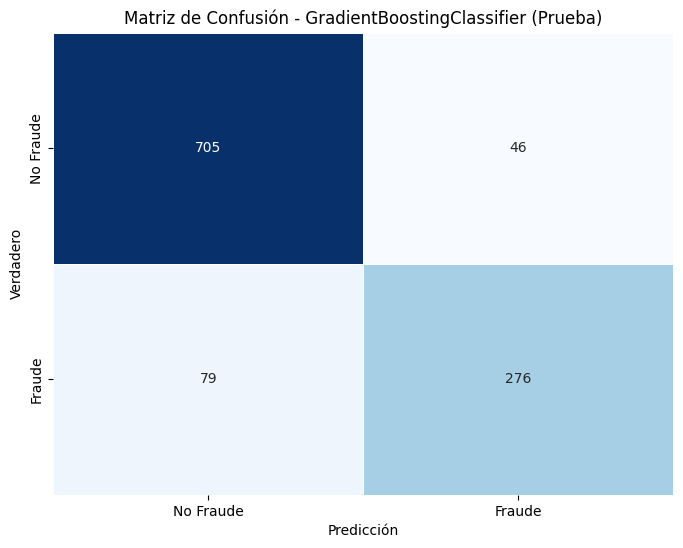

+----+----------------------------+---------------------------+------+------+------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


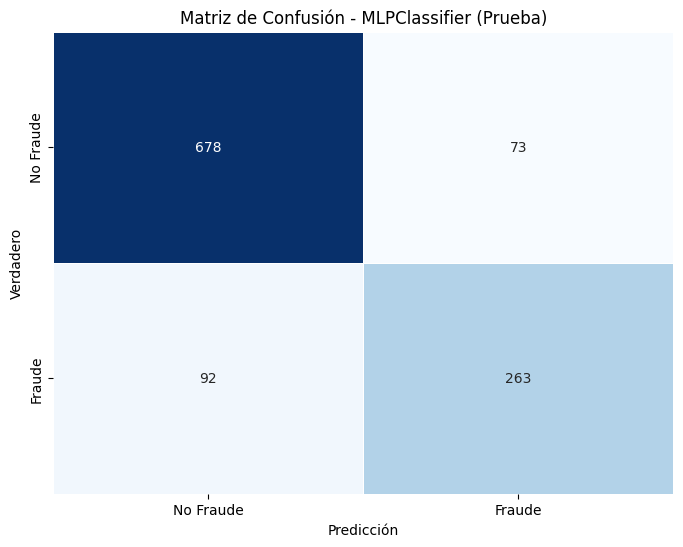

+----+---------------+---------------------------+------+------+------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Ruta del archivo
file_path = 'tabla_resultados.xlsx'

# Comprobar si el archivo existe
if os.path.exists(file_path):
    # Leer el archivo
    operacion_resultados = pd.read_excel(file_path)
else:
    # Inicializar el DataFrame vacío
    operacion_resultados = pd.DataFrame(columns=['Modelo', 'Parametrizacion', 'TP', 'FP', 'FN', 'TN', 'Variables input del modelo', 'Fecha de ejecucion del modelo', 'Comentarios'])

models = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),  # Naive Bayes Classifier
    AdaBoostClassifier(),  # AdaBoost Classifier
    GradientBoostingClassifier(),  # Gradient Boosting Classifier
    MLPClassifier()  # Multi-layer Perceptron Classifier
]

# Función para mostrar métricas y matriz de confusión
def print_evaluation_metrics(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Modelo: {model_name}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                annot_kws={"size": 10}, linewidths=0.5, 
                xticklabels=['No Fraude', 'Fraude'], 
                yticklabels=['No Fraude', 'Fraude'])
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()
    
    return cm

# Entrenar y evaluar cada modelo
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred_test = model.predict(X_test)
    cm = print_evaluation_metrics(f'{model_name} (Prueba)', y_test, y_pred_test)
    
    # Capturando detalles del modelo
    params = model.get_params() if hasattr(model, 'get_params') else 'default'
    params_json = json.dumps(params)
    input_variables = list(X_train.columns)
    execution_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Extraer TP, FP, FN, TN de la matriz de confusión
    tn, fp, fn, tp = cm.ravel()
    
    # Crear un nuevo DataFrame con los resultados
    new_row = pd.DataFrame({
        'Modelo': [model_name],
        'Comentarios': "Primera tirada de modelos",
        'TP': [tp],
        'FP': [fp],
        'FN': [fn],
        'TN': [tn],
        'Parametrizacion': [params_json],
        'Variables input del modelo': [input_variables],
        'Fecha de ejecucion del modelo': [execution_date]
    })
    
    # Concatenar el nuevo DataFrame con el DataFrame existente
    operacion_resultados = pd.concat([operacion_resultados, new_row], ignore_index=True)

    # Guardamos dataframe de resultados actualizados en su sitio
    operacion_resultados.to_excel(file_path, index=False)

    print(tabulate(new_row, headers='keys', tablefmt='psql'))



Ejemplo busqueda parametrica para la arquitectura xgboost me come los huevs

In [33]:
model = XGBClassifier()

# Define the expanded parameter grid for XGBClassifier
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01],
    'max_depth': [None, 3],
    'min_child_weight': [1, 3],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5],
    'scale_pos_weight': [1, 2, 5],
    'objective': ['binary:logistic', 'binary:hinge', 'binary:logitraw'],
    'booster': ['gbtree', 'dart'],
    'max_delta_step': [0, 1, 5],
    'eval_metric': ['logloss', 'auc']
}

# Generate all combinations of parameters
param_combinations = list(product(*param_grid.values()))

# Ruta del archivo
file_path = 'tabla_resultados.xlsx'

# Comprobar si el archivo existe
if os.path.exists(file_path):
    # Leer el archivo
    operacion_resultados = pd.read_excel(file_path)
else:
    # Inicializar el DataFrame vacío
    operacion_resultados = pd.DataFrame(columns=['Modelo', 'Parametrizacion', 'TP', 'FP', 'FN', 'TN', 'Variables input del modelo', 'Fecha de ejecucion del modelo', 'Comentarios'])


In [34]:
from datetime import datetime
import time

# Iniciar el tiempo al inicio del bucle
start_time = time.time()

# Pedir al usuario que especifique desde qué valor de i comenzar
# start_i = int(input("Ingrese el valor inicial de i: ")) # Esto es en caso de que se desee detener el entrenamiento y reiniciar desde el mismo punto
start_i = 0

# Iterar sobre todas las combinaciones de parámetros
for i, combination in enumerate(param_combinations[start_i:], start=start_i):
    # Crear un diccionario de parámetros para el modelo
    params = {key: combination[j] for j, key in enumerate(param_grid.keys())}

    print(f'Probando con parametrizacion {i+1}/{len(param_combinations)} con parametros: {params}.')

    # Crear y entrenar el modelo con esta configuración
    model = XGBClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        scale_pos_weight=params['scale_pos_weight'],
        objective=params['objective'],
        booster=params['booster'],
        max_delta_step=params['max_delta_step'],
        tree_method='hist',
        device='cuda',
        use_label_encoder=False,
        eval_metric=params['eval_metric'], 
    )

    model.fit(np.array(X_train), np.array(y_train))

    # Predecir los valores de test
    y_pred = model.predict(np.array(X_test))

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print('\n' + '-'*40 + '\n')

    # Añadir los valores de la nueva parametrización a la lista de resultados
    new_row = {
        'Modelo': 'XGBClassifier',
        'Parametrizacion': params,
        'TP': conf_matrix[1][1],
        'FP': conf_matrix[0][1],
        'FN': conf_matrix[1][0],
        'TN': conf_matrix[0][0],
        'Variables input del modelo': list(X_train.columns),
        'Fecha de ejecucion del modelo': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'Comentarios': 'Ejemplo XGBoost'
    }

    # Concatenar el nuevo DataFrame con el DataFrame existente
    operacion_resultados = pd.concat([operacion_resultados, pd.DataFrame([new_row])], ignore_index=True)

    # Guardar en el archivo Excel cada 100 iteraciones
    if (i + 1) % 10 == 0:
        operacion_resultados.to_excel(file_path, index=False)
        print(f"Guardado automático en el archivo Excel después de {i + 1} iteraciones.")

# Guardar el DataFrame actualizado en el archivo Excel al finalizar todas las iteraciones
operacion_resultados.to_excel(file_path, index=False)

end_time = time.time()
print(f"Grid search completed in {end_time - start_time} seconds.")


Probando con parametrizacion 1/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'max_delta_step': 0, 'eval_metric': 'logloss'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[726  25]
 [107 248]]

----------------------------------------

Probando con parametrizacion 2/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'max_delta_step': 0, 'eval_metric': 'auc'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[726  25]
 [107 248]]

----------------------------------------

Probando con parametrizacion 3/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'max_delta_step': 1, 'eval_metric': 'logloss'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[727  24]
 [107 248]]

----------------------------------------

Probando con parametrizacion 4/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'max_delta_step': 1, 'eval_metric': 'auc'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[727  24]
 [107 248]]

----------------------------------------

Probando con parametrizacion 5/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'max_delta_step': 5, 'eval_metric': 'logloss'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[727  24]
 [107 248]]

----------------------------------------

Probando con parametrizacion 6/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'max_delta_step': 5, 'eval_metric': 'auc'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[727  24]
 [107 248]]

----------------------------------------

Probando con parametrizacion 7/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'dart', 'max_delta_step': 0, 'eval_metric': 'logloss'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[728  23]
 [108 247]]

----------------------------------------

Probando con parametrizacion 8/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'dart', 'max_delta_step': 0, 'eval_metric': 'auc'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[728  23]
 [108 247]]

----------------------------------------

Probando con parametrizacion 9/62208 con parametros: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'booster': 'dart', 'max_delta_step': 1, 'eval_metric': 'logloss'}.


c:\Users\mjdiaz\.conda\envs\entorno_tfm\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 